# Universidad de Buenos Aires
# Aprendizaje Profundo - TP2
# Cohorte 20 - 3er bimestre 2025


Este segundo TP se debe entregar hasta las **23hs del domingo 17 de agosto (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP2 EQUIVALE AL 40% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/wgKVpFhX6F6Nfkf46)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP2.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP2-Co20.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **CLASIFICADOR DE EMOCIONES**

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/1pGsz3NFVHOfDpFG3jvpuM4NtpDCv757Z/view?usp=sharing

## 1. Preprocesamiento de Datos (2 puntos)

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan solo las técnicas que consideren pertinentes para este caso de uso en específico.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento.



In [1]:
import os
from typing import Tuple, Callable, Optional
import supervision as sv
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch
import torchinfo
import torchvision.transforms as T
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import (
    classification_report, 
    ConfusionMatrixDisplay, 
    accuracy_score,
    f1_score)


Exploring folder: dataset_emociones/train/seriedad
Exploring folder: dataset_emociones/train/sorpresa
Exploring folder: dataset_emociones/train/disgusto
Exploring folder: dataset_emociones/train/tristeza
Exploring folder: dataset_emociones/train/miedo
Exploring folder: dataset_emociones/train/enojo
Exploring folder: dataset_emociones/train/alegria


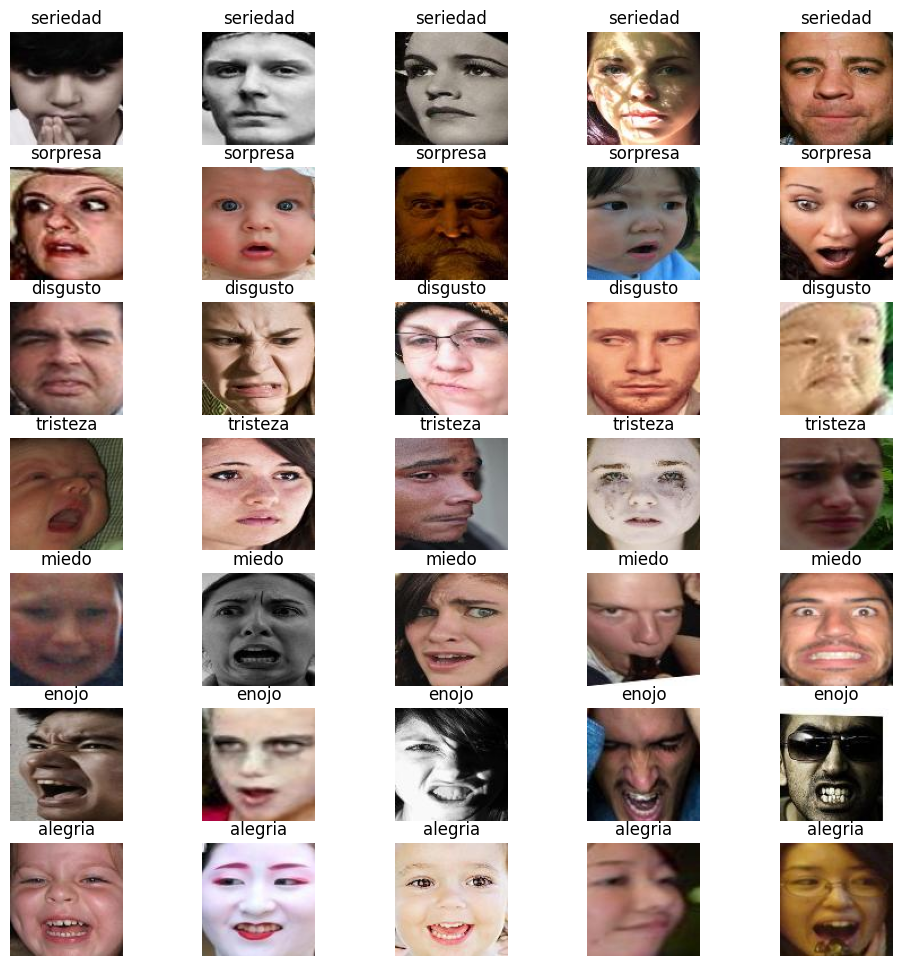

In [6]:
# Analisis exploratorio, imprimimos un par de imagenes por cada clase

DATA_PATH = 'dataset_emociones/train'

num_samples_to_show = 5
titles = list()
images = list()

for folder_name in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder_name)
    print(f"Exploring folder: {folder_path}")
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path)[:num_samples_to_show]:
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                titles.append(folder_name)
    
sv.plot_images_grid(images=images, titles=titles, grid_size=(len(set(titles)), num_samples_to_show))

Reestructuro el dataset para que sea mas manejable. Voy a crear un archivo csv con las etiquetas y paths
correspondientes a cada imagen, tanto para test como para train.

In [24]:
def is_image(file_name: str) -> bool:
    return file_name.lower().endswith(
        ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))    

def generate_image_csv(
    data_dir: str,
) -> pd.DataFrame:
    """
    Generate a CSV file with image paths and class labels.
    
    Parameters
    ----------
    data_dir:str
        Path to the root directory containing class-named folders of images.
    """
    data = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                if is_image(file_name=image_name):
                    data.append([os.path.join(class_path, image_name), class_name])
    return pd.DataFrame(data)

dataset_val = 'dataset_emociones/validation'
dataset_train = 'dataset_emociones/train'

df_train = generate_image_csv(data_dir=dataset_train)
df_val = generate_image_csv(data_dir=dataset_val)

df_train.to_csv('train.csv', index=False, header=False)
df_val.to_csv('validation.csv', index=False, header=False)

A partir de aca trabajamos con el dataset en el nuevo formato

7 classes in train dataset
7 classes in val dataset
Classes: ['seriedad' 'sorpresa' 'disgusto' 'tristeza' 'miedo' 'enojo' 'alegria']
Train dataset: 12271 images
Validation dataset: 3068 images
val / train ratio: 0.25 

Distribucion de clases en train 
-------------------------------
1
alegria     4772
seriedad    2524
tristeza    1982
sorpresa    1290
disgusto     717
enojo        705
miedo        281
Name: count, dtype: int64


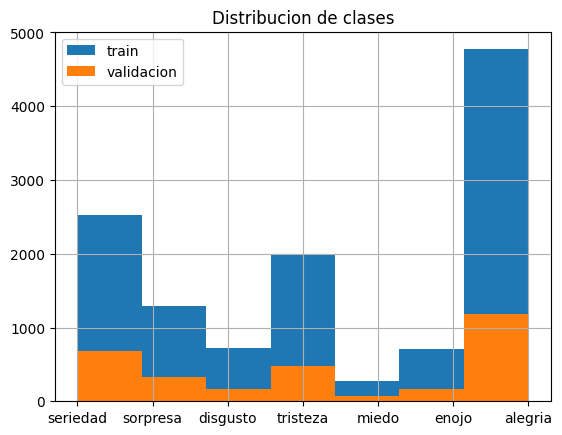

In [36]:
df_train = pd.read_csv('train.csv', header=None)
df_val = pd.read_csv('validation.csv', header=None)

print(f"{df_train[1].nunique()} classes in train dataset")
print(f"{df_val[1].nunique()} classes in val dataset")
print(f"Classes: {df_train[1].unique()}")
print(f"Train dataset: {len(df_train)} images")
print(f"Validation dataset: {len(df_val)} images")
print(f"val / train ratio: {len(df_val) / len(df_train):.2f} \n")

print("Distribucion de clases en train \n-------------------------------")
print(df_train[1].value_counts())

df_train[1].hist(bins=df_train[1].nunique())
df_val[1].hist(bins=df_val[1].nunique())
plt.title("Distribucion de clases")
plt.legend(["train", "validacion"])

Vemos que el dataset contiene imagenes de 100x100 pixeles. Con un fuerte desbalance para la clase "alegria", la
cual duplica en cantidad a la 2da clase mayoritaria (seriedad) y supera en un orden de magnitud a la minoritaria (miedo).
La distribucion de clases de validacion y train es proporcional entre ambos conjuntos, incluso se respeta el desbalance entre las clases mecionado arriba.


In [2]:
# Dataset y dataloader

class ImgClassificationDataset(Dataset):

    IMG_CLASS_COL = 1

    def __init__(self, dataset_csv:str, transform=None):
        """
        Parameters
        ----------
        dataset_csv:str
            Path to a csv file contaning image name and class labels
        """
        super().__init__()

        self.transform = transform
        self._dataset_df = pd.read_csv(dataset_csv, header=None)
        self.labels = list(set(self._dataset_df[self.IMG_CLASS_COL]))
        self.label2id = {label:i for i, label in enumerate(self.labels)}
        self.id2label = {i:label for i, label in enumerate(self.labels)}

    def __getitem__(self, index):
        # store as attributes for further usage
        self.image_path, self.class_name = self._dataset_df.loc[index]
        image_bgr = cv2.imread(self.image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        if self.transform:
            image_rgb = self.transform(image_rgb)
        return image_rgb, self.label2id[self.class_name]

    def __len__(self):
        return len(self._dataset_df)

transforms = T.Compose([
    T.ToTensor(),
    # T.RandomHorizontalFlip(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImgClassificationDataset(
    dataset_csv='train.csv', transform=transforms)
val_dataset = ImgClassificationDataset(
    dataset_csv='validation.csv', transform=val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

## 2. Construcción y entrenamiento del Modelo CNN (3.5 puntos)

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, tanaño de kernel, entre otros, queda a criterio de ustedes, pero deben estar justificadas.

In [3]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, intermediate_channels, stride):
        
        """
        Creates a residual block that adds the input feature maps to the output
        feature maps of the block.
        
        Parameters
        ----------
        in_channels : int
            Number of input channels to the block
        intermediate_channels : int
            Number of channels in the intermediate convolution layers
        stride : int
            Stride for the convolution layers in the block
        """

        super(ResBlock, self).__init__()

        self.in_channels = in_channels
        self.intermediate_channels = intermediate_channels
        
        # i.e. if dim(x) == dim(F) => Identity function
        if self.in_channels == self.intermediate_channels:
            self.identity = True
        else:
            self.identity = False
            projection_layer = []
            projection_layer.append(nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=1, stride=stride, padding=0, bias=False ))
            projection_layer.append(nn.BatchNorm2d(self.intermediate_channels))
            # Only conv->BN and no ReLU
            # projection_layer.append(nn.ReLU())
            self.projection = nn.Sequential(*projection_layer)

        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(
            in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
        self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)
            
        self.conv2 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False )
        self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)

    def forward(self, x):
        
        in_x = x # save to be summed at the output

        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.batchnorm2(self.conv2(x))
        # identity or projected mapping
        if self.identity:
            x += in_x
        else:
            x += self.projection(in_x)
        x = self.relu(x)
        
        return x


class ResNet18(nn.Module):

    def __init__(
        self, 
        num_classes: int, 
        in_channels: int = 3
    ):
        """
        ResNet18 architecture modelization.

        Parameters
        ----------
        num_classes : int
            Number of classes for the classification head
        in_channels : int
            Number of input channels, by default 3 (RGB images)
        """
        super(ResNet18, self).__init__()
        self.channels_list = [64, 128, 256, 512] # resnet filters per layer
        self.repetition_list = [2, 2, 2, 2] # block repetition per layer

        # First conv block at the network input. This block never repeats.
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Create residual blocks 
        self.block1 = self._make_blocks(64, self.channels_list[0], self.repetition_list[0], stride=1 )
        self.block2 = self._make_blocks(self.channels_list[0], self.channels_list[1], self.repetition_list[1], stride=2)
        self.block3 = self._make_blocks(self.channels_list[1], self.channels_list[2], self.repetition_list[2], stride=2)
        self.block4 = self._make_blocks(self.channels_list[2], self.channels_list[3], self.repetition_list[3], stride=2)

        # Output block with classification head
        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(self.channels_list[3], num_classes)

    def forward(self,x):

        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        
        return x

    def _make_blocks(
        self,
        in_channels,
        intermediate_channels, 
        num_repeat, 
        stride):
        
        """
        Create a sequence of residual blocks.

        Parameters
        ----------
        in_channels : int
            Number of input channels to the first block
        intermediate_channels : int
            Number of channels in the intermediate convolution layers
        num_repeat : int
            Number of residual blocks to create in the sequence
        """
        layers = [] 

        layers.append(ResBlock(in_channels, intermediate_channels, stride=stride))
        for _ in range(1, num_repeat):
            layers.append(ResBlock(intermediate_channels, intermediate_channels, stride=1))

        return nn.Sequential(*layers)

In [14]:
model = ResNet18(num_classes=len(train_dataset.label2id))
torchinfo.summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─ResBlock: 2-1                     [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [16]:
def compute_metrics(
    model: nn.Module, 
    data: DataLoader, 
    loss_fn: Optional[Callable] = None
) -> Tuple[float, float, Optional[float]]:
    """
    Evaluates the model on the given data loader. Computes accuracy, f1 score 
    and loss (if loss_fn is provided).
    
    Parameters
    ----------
    model: nn.Module
        The PyTorch model to evaluate.
    data: DataLoader
        The DataLoader containing the dataset to evaluate on.
    loss_fn: Optional[Callable]:
        Loss function to compute loss, if None, loss is not computed.
        
    Returns
    -------
    accuracy: float
        Accuracy score of the model on the dataset.
    f1_score: float
        F1 score of the model on the dataset.
    loss: Optional[float]
        Loss value if loss_fn is provided, otherwise None.
    """
    model.eval()

    loss = 0
    y_true = list()
    y_pred = list()
    batch_count = 0

    with torch.no_grad():
        for images, labels in tqdm(data):

            batch_count += 1
            outputs = model(images.to('cuda'))
            _, preds = torch.max(outputs, 1)
            y_true.extend(val_dataset.id2label[label] for label in labels.numpy())
            y_pred.extend(val_dataset.id2label[pred] for pred in preds.cpu().numpy())
            if loss_fn is not None:
                loss += loss_fn(outputs.cpu(), labels).item()

    loss = loss / batch_count if loss_fn is not None else None

    f1 = f1_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average='weighted')  # wheighted average to consider class imbalance

    accuracy = accuracy_score(
        y_true=y_true, 
        y_pred=y_pred)

    return accuracy, f1, loss

In [17]:
EPOCHS = 30
LR = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
model.to('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_avg = list()
train_accuracy = list()
train_f1 = list()

val_loss = list()
val_accuracy = list()
val_f1 = list()

for epoch in range(EPOCHS):
    model.train()

    y_pred = list()
    y_true = list()

    train_loss_avg.append(0)

    batch_count = 0
    for images, labels in tqdm(train_loader):

        batch_count += 1
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss_avg[-1] += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append predictions and true labels for train metrics computation
        _, preds = torch.max(outputs, 1)
        y_true.extend(train_dataset.id2label[label] for label in labels.cpu().numpy())
        y_pred.extend(train_dataset.id2label[pred] for pred in preds.cpu().numpy())

    ########### Evaluation phase ###########

    # Eval on training set
    train_loss_avg[-1] /= batch_count
    train_accuracy.append(
        accuracy_score(y_true=y_true, y_pred=y_pred))
    train_f1.append(f1_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average='weighted'))  # wheighted average to consider class imbalance

    # Eval on validation set
    val_accuracy_epoch, val_f1_epoch, val_loss_epoch = compute_metrics(
        model=model, data=val_loader, loss_fn=loss_fn)

    val_loss.append(val_loss_epoch)
    val_accuracy.append(val_accuracy_epoch)
    val_f1.append(val_f1_epoch)

    # Step the learning rate scheduler
    lr_scheduler.step(metrics=val_loss_epoch)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}]: Train Loss avg: {train_loss_avg[-1]:.4f} Val loss: {val_loss[-1]:.4f}")
    print(
        f"Train Acc: {train_accuracy[-1]:.4f} Val Acc: {val_accuracy[-1]:.4f}")


100%|██████████| 96/96 [00:03<00:00, 31.85it/s]


Epoch [1/30]: Train Loss avg: 1.6463 Val loss: 1.5410
Train Acc: 0.3879 Val Acc: 0.4172


100%|██████████| 96/96 [00:03<00:00, 28.38it/s]


Epoch [2/30]: Train Loss avg: 1.4278 Val loss: 1.2538
Train Acc: 0.4704 Val Acc: 0.5372


100%|██████████| 96/96 [00:03<00:00, 29.50it/s]


Epoch [3/30]: Train Loss avg: 1.1042 Val loss: 1.0097
Train Acc: 0.5968 Val Acc: 0.6447


100%|██████████| 96/96 [00:03<00:00, 29.98it/s]


Epoch [4/30]: Train Loss avg: 0.9200 Val loss: 0.9483
Train Acc: 0.6678 Val Acc: 0.6649


100%|██████████| 96/96 [00:03<00:00, 29.26it/s]


Epoch [5/30]: Train Loss avg: 0.8113 Val loss: 0.8879
Train Acc: 0.7088 Val Acc: 0.6962


100%|██████████| 96/96 [00:03<00:00, 30.71it/s]


Epoch [6/30]: Train Loss avg: 0.7100 Val loss: 0.7915
Train Acc: 0.7426 Val Acc: 0.7223


100%|██████████| 96/96 [00:03<00:00, 30.51it/s]


Epoch [7/30]: Train Loss avg: 0.6290 Val loss: 0.7568
Train Acc: 0.7741 Val Acc: 0.7347


100%|██████████| 96/96 [00:03<00:00, 31.34it/s]


Epoch [8/30]: Train Loss avg: 0.5263 Val loss: 0.7047
Train Acc: 0.8129 Val Acc: 0.7617


100%|██████████| 96/96 [00:03<00:00, 31.61it/s]


Epoch [9/30]: Train Loss avg: 0.4285 Val loss: 0.8275
Train Acc: 0.8439 Val Acc: 0.7145


100%|██████████| 96/96 [00:03<00:00, 31.20it/s]


Epoch [10/30]: Train Loss avg: 0.3340 Val loss: 0.8270
Train Acc: 0.8802 Val Acc: 0.7438


100%|██████████| 96/96 [00:03<00:00, 31.83it/s]


Epoch [11/30]: Train Loss avg: 0.2373 Val loss: 0.8529
Train Acc: 0.9165 Val Acc: 0.7591


100%|██████████| 96/96 [00:03<00:00, 31.19it/s]


Epoch [12/30]: Train Loss avg: 0.1725 Val loss: 0.9713
Train Acc: 0.9378 Val Acc: 0.7608


100%|██████████| 96/96 [00:03<00:00, 30.78it/s]


Epoch [13/30]: Train Loss avg: 0.1230 Val loss: 1.0282
Train Acc: 0.9585 Val Acc: 0.7614


100%|██████████| 96/96 [00:03<00:00, 29.52it/s]


Epoch [14/30]: Train Loss avg: 0.1178 Val loss: 1.2118
Train Acc: 0.9582 Val Acc: 0.7347


100%|██████████| 96/96 [00:03<00:00, 29.21it/s]


Epoch [15/30]: Train Loss avg: 0.0425 Val loss: 0.9111
Train Acc: 0.9865 Val Acc: 0.7774


100%|██████████| 96/96 [00:03<00:00, 29.15it/s]


Epoch [16/30]: Train Loss avg: 0.0176 Val loss: 0.9172
Train Acc: 0.9967 Val Acc: 0.7803


100%|██████████| 96/96 [00:03<00:00, 29.89it/s]


Epoch [17/30]: Train Loss avg: 0.0120 Val loss: 0.9237
Train Acc: 0.9988 Val Acc: 0.7823


100%|██████████| 96/96 [00:03<00:00, 30.90it/s]


Epoch [18/30]: Train Loss avg: 0.0082 Val loss: 0.9302
Train Acc: 0.9996 Val Acc: 0.7839


100%|██████████| 96/96 [00:03<00:00, 28.53it/s]


Epoch [19/30]: Train Loss avg: 0.0067 Val loss: 0.9409
Train Acc: 0.9994 Val Acc: 0.7914


100%|██████████| 96/96 [00:03<00:00, 30.52it/s]


Epoch [20/30]: Train Loss avg: 0.0054 Val loss: 0.9636
Train Acc: 0.9997 Val Acc: 0.7846


100%|██████████| 96/96 [00:03<00:00, 31.13it/s]


Epoch [21/30]: Train Loss avg: 0.0043 Val loss: 0.9725
Train Acc: 1.0000 Val Acc: 0.7881


100%|██████████| 96/96 [00:03<00:00, 29.38it/s]


Epoch [22/30]: Train Loss avg: 0.0040 Val loss: 0.9534
Train Acc: 0.9999 Val Acc: 0.7868


100%|██████████| 96/96 [00:03<00:00, 31.16it/s]


Epoch [23/30]: Train Loss avg: 0.0037 Val loss: 0.9596
Train Acc: 0.9999 Val Acc: 0.7865


100%|██████████| 96/96 [00:03<00:00, 29.42it/s]


Epoch [24/30]: Train Loss avg: 0.0048 Val loss: 0.9613
Train Acc: 0.9996 Val Acc: 0.7872


100%|██████████| 96/96 [00:03<00:00, 29.06it/s]


Epoch [25/30]: Train Loss avg: 0.0034 Val loss: 0.9654
Train Acc: 1.0000 Val Acc: 0.7859


100%|██████████| 96/96 [00:03<00:00, 30.31it/s]


Epoch [26/30]: Train Loss avg: 0.0035 Val loss: 0.9790
Train Acc: 0.9998 Val Acc: 0.7881


100%|██████████| 96/96 [00:03<00:00, 30.43it/s]


Epoch [27/30]: Train Loss avg: 0.0033 Val loss: 0.9704
Train Acc: 0.9998 Val Acc: 0.7868


100%|██████████| 96/96 [00:03<00:00, 29.60it/s]


Epoch [28/30]: Train Loss avg: 0.0036 Val loss: 0.9654
Train Acc: 1.0000 Val Acc: 0.7888


100%|██████████| 96/96 [00:03<00:00, 30.20it/s]


Epoch [29/30]: Train Loss avg: 0.0031 Val loss: 0.9684
Train Acc: 0.9999 Val Acc: 0.7878


100%|██████████| 96/96 [00:03<00:00, 31.19it/s]

Epoch [30/30]: Train Loss avg: 0.0033 Val loss: 0.9815
Train Acc: 0.9999 Val Acc: 0.7875


## 3. Evaluación del Modelo (2.5 puntos)

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.


In [18]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predicted = predicted.cpu()

        y_true.extend(val_dataset.id2label[label] for label in labels.numpy())
        y_pred.extend(val_dataset.id2label[pred] for pred in predicted.cpu().numpy())

100%|██████████| 96/96 [00:03<00:00, 28.41it/s]


Guardamos el modelo

In [22]:
torch.save(model.state_dict(), 'resnet18_emotions.pth')

Accuracy and F1

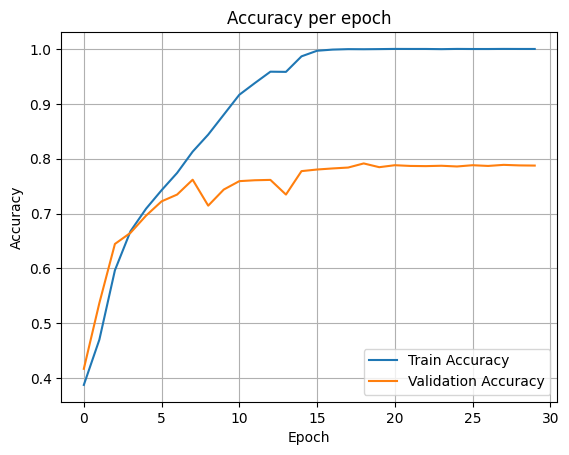

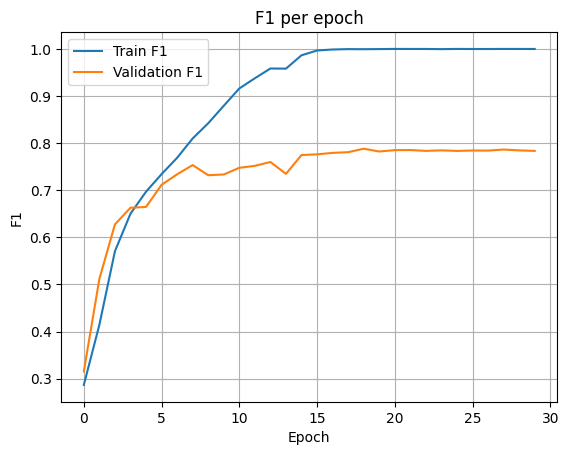

In [19]:
plt.plot(range(EPOCHS), train_accuracy, label='Train Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.title("Accuracy per epoch")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid('minor')
plt.show()

plt.plot(range(EPOCHS), train_f1, label='Train F1')
plt.plot(range(EPOCHS), val_f1, label='Validation F1')
plt.title("F1 per epoch")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.grid('minor')
plt.show()

Loss

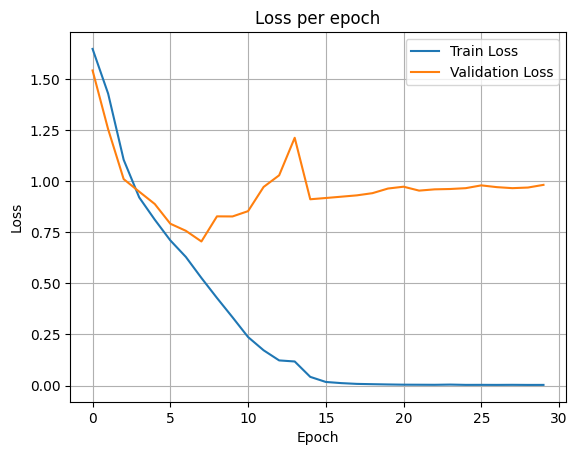

In [20]:
plt.plot(range(EPOCHS), train_loss_avg, label='Train Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title("Loss per epoch")
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('minor')

              precision    recall  f1-score   support

     alegria       0.89      0.91      0.90      1185
    tristeza       0.56      0.40      0.47       160
    disgusto       0.71      0.67      0.69       162
       enojo       0.69      0.47      0.56        74
       miedo       0.73      0.80      0.76       680
    seriedad       0.79      0.78      0.79       329
    sorpresa       0.72      0.68      0.70       478

    accuracy                           0.79      3068
   macro avg       0.72      0.67      0.69      3068
weighted avg       0.78      0.79      0.78      3068



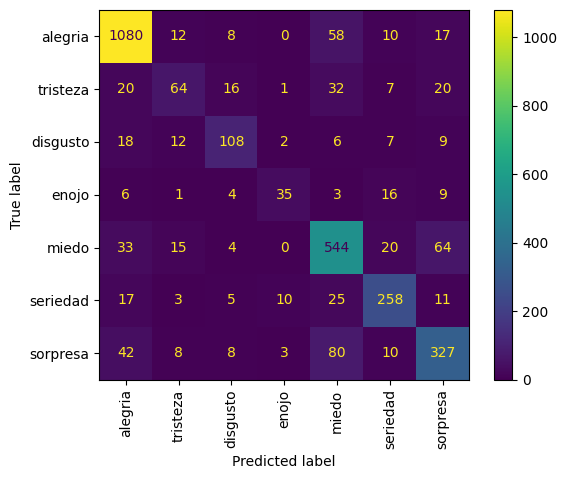

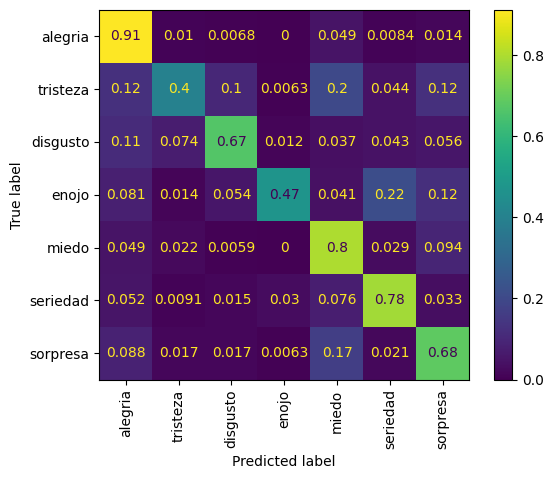

In [21]:
print(classification_report(y_true, y_pred, target_names=val_dataset.labels))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=val_dataset.labels, xticks_rotation='vertical')
plt.show()
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=val_dataset.labels, xticks_rotation='vertical', normalize='true')
plt.show()

 ## 4. Prueba de Imágenes Nuevas (1 punto)
Subir al menos 5 imágenes personales de cualquier relación de aspecto (pueden usar fotos del rostro de ustedes, rostros de personas generadas por IA o imágenes stock de internet), que no formen parte del dataset de entrenamiento ni de validación.

- Cada imagen debe representar una emoción distinta.

- Aplicar el mismo pre-procesamiento que se usó para el dataset durante el entrenamiento del modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Redactar conclusiones preliminares

Imagenes originales y pre-procesadas

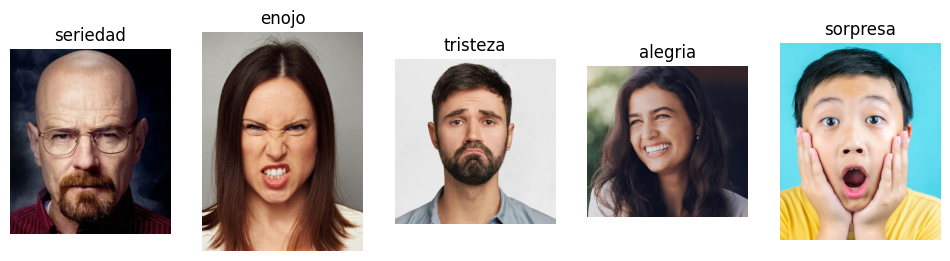

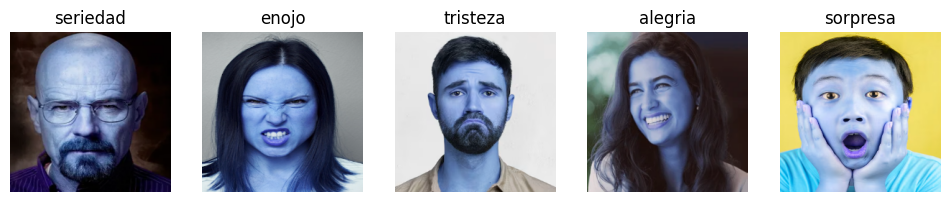

In [40]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

TEST_DATA = './test_faces'
images = list()
labels = list()

for img_file in os.listdir(TEST_DATA):
    if is_image(file_name=img_file):
        img_bgr = cv2.imread(os.path.join(TEST_DATA, img_file))
        images.append(img_bgr)
        labels.append(img_file.split('.')[0])

# Excluimos la normalizacion y el pasaje a tensor ya que necesitamos las
# imagenes con tipo de dato uint8 para visualizarlas. Solo uncluimos el resize
# y el cambio de color a RGB que se aplica en nuestra clase Dataset.
images_preproc = [cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), dsize=(224, 224)) for img in images]

sv.plot_images_grid(images=images, titles=labels, grid_size=(1, len(set(labels))))
sv.plot_images_grid(images=images_preproc, titles=labels, grid_size=(1, len(set(labels))))

Al cambiar el orden de los canales la biblioteca de visualizacion interpreta mal los colores, se excluyo la normalizacion del procesamiento ya que esto haria que las imagenes no se visualicen correctamente, estas deben estar en uint8 para poder ser mostradas.

In [45]:
input_tensors = [transforms(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) for img in images]
input_tensors = torch.stack(input_tensors).to('cuda')
model.eval()
with torch.no_grad():
    outputs = model(input_tensors)
    all_scores = torch.nn.functional.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)
    scores, _ = torch.max(all_scores, 1)

preds = preds.cpu().numpy()
scores = scores.cpu().numpy()
predicted_labels = [val_dataset.id2label[pred] for pred in preds]

print(f"Predicted labels: {predicted_labels}")
print(f"Scores: {scores}")

Predicted labels: ['enojo', 'enojo', 'tristeza', 'tristeza', 'miedo']
Scores: [0.45983672 0.87089086 0.97990626 0.51078767 0.9431549 ]


### Conclusiones preliminares

Las imagenes elegidas presentan diferentes relaciones de aspecto y poseen mas "fondo" que las del dataset, estas ultimas contienen una roi con la cara ocupando la totalidad de la imagen lo que hace que el modelo no pueda identificar correctamente la emocion en ciertos casos. Vemos que la probabilidad asignada a la clase ganadora en las imagenes 1 y 4 es baja. Por otro lado, y esto es subjetivo, pero la imagen elegida como sorpresa podria catalogarse dentro de `miedo` ya que asemeja a una persona gritando confundiendo la emocion, algo similar sucede con la imagen 1 donde la `seriedad` pude confundirse con `tristeza` o `enojo`. Se clasifico correctamente 2 de las 5 imagenes, lo que no es un resultado alentador pero es esperable dado que el modelo no fue entrenado con imagenes de este tipo.

 ## 5. Prueba de Imágenes Nuevas con Pre-procesamiento Adicional (1 punto)
Las 5 imágenes del punto 4, ahora serán pasadas y recortadas por un algoritmo de detección de rostros. Usen el siguiente código para realizar un pre-procesamiento inicial de la imagen y ya luego aplican el pre-procesamiento que usaron al momento de entrenar el modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:
  - La imagen original
  - La imagen recortada por el algoritmo
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Comparar los resultados con el punto 4 y redactar conclusiones finales.

NOTA: Pueden adaptar el código según crean conveniente para obtener mejores resultados.

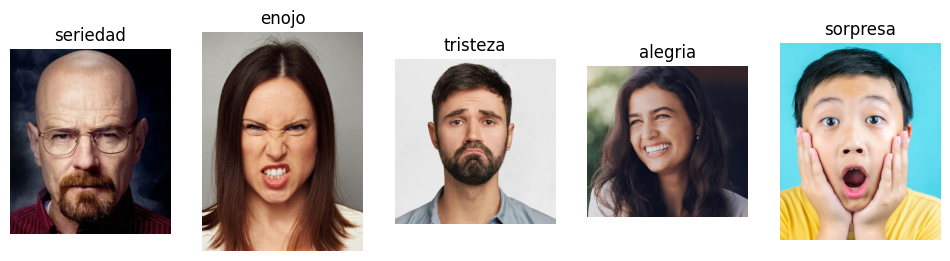

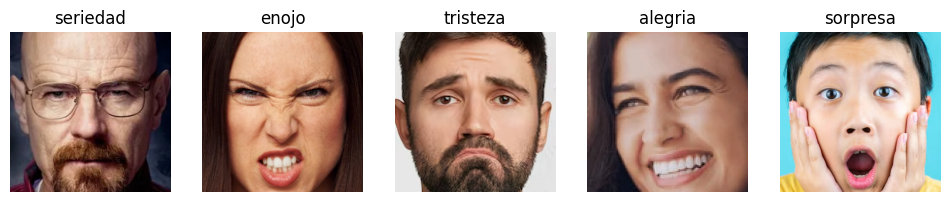

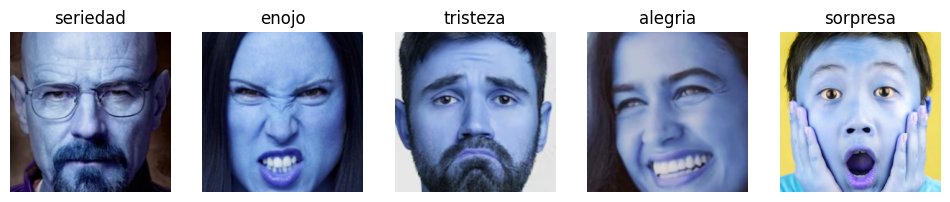

In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cropped_faces = list()

for image in images:

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6)

    image_with_box = image.copy()
    for (x, y, w, h) in faces:
        cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cropped_face_rgb = None
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        center_x, center_y = x + w // 2, y + h // 2
        side = max(w, h)
        half_side = side // 2

        x1 = max(center_x - half_side, 0)
        y1 = max(center_y - half_side, 0)
        x2 = min(center_x + half_side, image.shape[1])
        y2 = min(center_y + half_side, image.shape[0])

        cropped_face = image[y1:y2, x1:x2]
        cropped_faces.append(cropped_face)
    else:
        # Si no se detecto rosto agregamos la imagen original para procesar en orden
        cropped_faces.append(image)

images_preproc = [cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), dsize=(224, 224)) for img in cropped_faces]

sv.plot_images_grid(images=images, titles=labels, grid_size=(1, len(set(labels))))
sv.plot_images_grid(images=cropped_faces, titles=labels, grid_size=(1, len(set(labels))))
sv.plot_images_grid(images=images_preproc, titles=labels, grid_size=(1, len(set(labels))))

In [49]:
input_tensors = [transforms(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) for img in cropped_faces]
input_tensors = torch.stack(input_tensors).to('cuda')
model.eval()
with torch.no_grad():
    outputs = model(input_tensors)
    all_scores = torch.nn.functional.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)
    scores, _ = torch.max(all_scores, 1)

preds = preds.cpu().numpy()
scores = scores.cpu().numpy()
predicted_labels = [val_dataset.id2label[pred] for pred in preds]

print(f"Predicted labels: {predicted_labels}")
print(f"Scores: {scores}")

Predicted labels: ['tristeza', 'enojo', 'tristeza', 'alegria', 'enojo']
Scores: [0.97711366 0.75547034 0.9997143  0.9970989  0.98956954]


### Comparacion de resultados y conclusiones

Las imagenes recortadas por el algoritmo de deteccion de rostros permiten al modelo identificar mejor las emociones, ya que se eliminan los fondos y se centra en la cara. En este caso, el modelo logra clasificar correctamente 3 de las 5 imagenes, presentando scores mas altos a diferencia del caso anterior. Es curioso que se presenta algo que se anticipo en las conclusiones preliminares del punto 4: la imagen 1 que antes se clasificaba como `enojo` ahora es clasificada como `tristeza` (las conclusiones del item anterior se redactaron antes de obtener los resultados del item 5) Esto puede deberse a que las emociones son subjetivas y pueden variar de persona a persona, por lo que el modelo puede no ser capaz de generalizar correctamente estos casos de borde.